## Repetition Effects
While previous analyses evince that our prototype-based and instance-based implementations of CMR equivalently account for free recall performance when each unique item is presented just once during study, there is reason to suspect that the models might diverge when it comes to accounting for the effect of item repetition on later free recall.

Previous work [@siegel2014retrieved] has related CMR to two broad accounts of how item repetition influences memory and in particular drives the spacing effect, a monotonic relationship between recall probability and the size of the lag between item repetitions in a study list. Under the contextual-variability account [@anderson1972recognition], each time an item is studied, it's associated in memory with the current state of a slowly drifting contextual representation. Depending on how spaced apart two presentations of an item might be, the contextual states they are associated with might either be very similar or very distinct. Later, participants use the current state of their contextual representation to probe their memories and retrieve items during free recall. When an item has been associated with diverse contextual states, it can correspondingly be retrieved using diverse possible cues. In this way, the improvements in recall we gain from spacing presentations of an item are explained in terms of variation in the range of possible cues that can trigger recall of that item. A study-phase retrieval account of the spacing effect alternatively emphasizes the consequences of studying a successively presented item. According to the account, when this happens we retrieve memories of the repeated item's earlier occurrences and their associated contexts. When this happens, it's proposed that retrieved information is memorally associated with information corresponding to the current presentation context.

Analyses of our instance-based implementation of CMR so far suggest it realizes these mechanisms similarly to the original prototype-based CMR. A potentially more relevant distinction between the models might instead turn on differences in how records of past experience are integrated for retrieval. InstanceCMR, like MINERVA 2, has the option to apply its nonlinear activation scaling parameter $\tau$ to activations of individual traces - that is, before integration into a unitary vector tracking retrieval support. However, CMR does not access trace activations and applies $\tau$ to the integrated echo representation result.

This distinction between instance-based and prototype-based architectures has been marshalled to explain model differences in other research contexts [e.g., @jamieson2018instance]. In this context, however, the different between applying $\tau$ to trace activations or echo content is between enforcing quasi-linear or quasi-exponential effect of item repetition on subsequent recall probability. Suppose a constant sensitivity parameter $\tau$ and that two distinct experiences each contributed a support of $c$ for a given feature unit in the current recall. Under trace-based sensitivity scaling, the retrieval support for that feature unit would be $c^{\tau} + c^{\tau}$. But under echo-based sensitivity scaling, support would be ${(c + c)}^{\tau}$, a much larger quantity.

Another way to illustrate this architectural difference is by simulation. We can have our prototype-based and each variant of our instance-based implementation of CMR simulate a traditional list-learning experiment with study of 20 unique items in order. Then, we can simulate repeated study of an arbitrary item in that list and measure the effect on the probability of retrieving that item for each successive repetition given a static retrieval cue. [Figure @fig-repeffect] plots the result of of this simulation over 1000 experiments for 50 item repetitions using PrototypeCMR and InstanceCMRand model parameters fitted using data from @murdock1970interresponse and corresponds with our predictions. Model fitting over a different dataset might obviate these observed differences; however these simulations raise the possibility that with increasing item repetitions, prototype-based and instance-based implementations of CMR might support different predictions about the influence of item repetition on later recall probability, motivating further investigation.

In [11]:
#| code-summary: code -- 1) load simulation dependencies and set general parameters
import numpy as np
import matplotlib.pyplot as plt
from numba.typed import Dict
from numba.core import types
from compmemlearn.models import Classic_CMR, Instance_CMR
import seaborn as sns
sns.set(style='darkgrid')

experiment_count = 1000
item_count = 20
presentation_count = 70

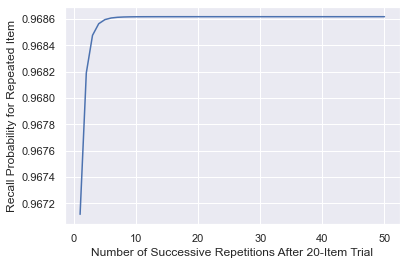

In [12]:
#| code-summary: code -- 2) using PrototypeCMR, simulate repeated encoding of arbitrary item after normal trial 50 times and plot variation in recall probability given a static cue

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

cmr_fit_values = np.array([5.79524319e-01, 4.07083020e-03, 7.24717634e-01, 7.47425733e-01,
       1.00000000e+00, 9.58358158e-02, 9.55947397e+00, 8.71434638e+01,
       3.13827247e-02, 3.36754300e-01, 9.25336064e+00, 9.95710836e-01])

parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for index, name in enumerate(cmr_free_parameters):
    parameters[name] = cmr_fit_values[index]
    
parameters['sampling_rule'] = 0
parameters['mfc_familiarity_scale'] = 0
parameters['mcf_familiarity_scale'] = 0
parameters['drift_familiarity_scale'] = 0

results = np.zeros((experiment_count, 1+presentation_count-item_count))

for experiment in range(experiment_count):
    # arbitrary item and contextual cue
    repeated_item = 0
    
    # initialize model
    model = Classic_CMR(item_count, presentation_count, parameters)
    cue = model.context
    model.experience(model.items)
    results[experiment, 0] = np.nan 
    
     # track outcome probability of selected item as it is repeatedly encoded
    for i in range(presentation_count - item_count):
        
        model.experience(model.items[repeated_item:repeated_item+1])
        
        if i == 0:
            cue = model.context
        
        pre_cue_context = model.context.copy()
        model.context = cue
        results[experiment, i+1] = model.outcome_probabilities()[repeated_item+1]
        model.context = pre_cue_context
        
plt.plot(np.mean(results, axis=0))
plt.xlabel('Number of Successive Repetitions After 20-Item Trial')
plt.ylabel('Recall Probability for Repeated Item')
plt.savefig('cmr_repeffect.pdf', bbox_inches="tight")
plt.show()

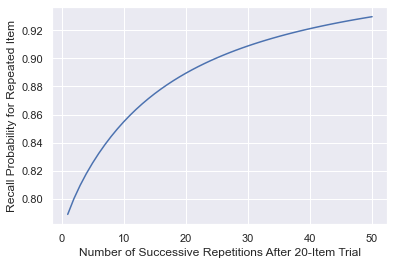

In [13]:
#| code-summary: code -- 2) using InstanceCMR, simulate repeated encoding of arbitrary item after normal trial 50 times and plot variation in recall probability given a static cue

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
#    'feature_sensitivity',
    'context_sensitivity',
    'delay_drift_rate',
)

icmr_fit_values = np.array([7.25274023e-01, 5.49552946e-03, 7.76637231e-01, 6.81235304e-03,
       1.00000000e+00, 2.88780665e-01, 6.21718894e+00, 2.83467864e+01,
       2.40239395e-02, 2.61909193e-01, 1.63472597e+00, 9.45953503e-01])

parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for index, name in enumerate(icmr_free_parameters):
    parameters[name] = icmr_fit_values[index]
    
parameters['sampling_rule'] = 0
parameters['choice_sensitivity'] = 1
parameters['feature_sensitivity'] = 1

results = np.zeros((experiment_count, 1+presentation_count-item_count))

for experiment in range(experiment_count):
    # arbitrary item and contextual cue
    repeated_item = 0
    
    # initialize model
    model = Instance_CMR(item_count, presentation_count, parameters)
    cue = model.context
    model.experience(model.items)
    results[experiment, 0] = np.nan 
    
     # track outcome probability of selected item as it is repeatedly encoded
    for i in range(presentation_count - item_count):
        
        model.experience(model.items[repeated_item:repeated_item+1])
        
        if i == 0:
            cue = model.context
        
        #cue = model.context # for when i want context to be the cue
        pre_cue_context = model.context.copy()
        model.context = cue
        results[experiment, i+1] = model.outcome_probabilities()[repeated_item+1]
        model.context = pre_cue_context
        
plt.plot(np.mean(results, axis=0))
plt.xlabel('Number of Successive Repetitions After 20-Item Trial')
plt.ylabel('Recall Probability for Repeated Item')
plt.savefig('icmr_repeffect.pdf', bbox_inches="tight")
plt.show()

::: {#fig-repeffect layout-ncol=2 layout-valign="center"}

![PrototypeCMR](cmr_repeffect.pdf){#fig-cmr_repeffect}

![InstanceCMR](icmr_repeffect.pdf){#fig-icmr_repeffect}

Course of effect of successive item repetitions on recall probability, by model, using parameters fitted over @murdock1970interresponse dataset and a static contextual cue after simulation of a pure 20-item list.
:::

Though initial simulations suggest a way to distinguish between instance- and prototype-based accounts of context maintenance and retrieval, free recall datasets with high amounts of repetition to the extent simulated in the above example do not yet exist. However, to support an initial comparison of how models account for item repetition effects, we use data associated with @siegel2014retrieved. Within the dataset, 35 subjects performed delayed free recall of 48 lists over four sessions. Except for deliberate item repetitions, words were unique within each session and did not repeat in successive sessions. The semantic relatedness of words was also controlled below a value of .55 according to WAS [@steyvers2005word]. Across trials, lists were structured in four different ways:

1.  In control lists, all items were only presented once.

2.  In pure massed lists, items were presented twice, always in succession (e.g. 1, 1, 2, 2)

3.  In pure spaced lists, items were presented twice with spacing of repetitions from 1 to 8 positions, with each spacing amount equiprobable.

4.  Finally, mixed lists feature once-presented, massed, and spaced items, with each spacing amount equiprobable

In [15]:
#| code-summary: code -- 1) load dependencies and data
from compmemlearn.fitting import lohnas_objective_function, apply_and_concatenate
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_data
from compmemlearn.models import Classic_CMR, Instance_CMR
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
import matplotlib.pyplot as plt
from numba.core import types
from numba import njit
import seaborn as sns
from psifr import fr
import pandas as pd
import numpy as np

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

As with previous analyses, each model variant was fit once for each participant to identify the parameter configuration maximizing the likelihood of observed recall sequences given the considered model, considering all conditions of the dataset. The distribution of data log-likelihoods given each fitted model and participant are plotted in [Figure @fig-LohnasFits], with median values for each model variant highlighted. Similarly to previous analyses, these value distributions were found largely similar. The distribution of log-likelihood scores between participants for the PrototypeCMR and InstanceCMR model variants only marginally differ, suggesting that all considered model variants can predict recall sequences even when item repetitions occur during study with similar degrees of success.

In [16]:
#| output: false
#| code-summary: code -- 2) fit PrototypeCMR participant-by-participant

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

individual_cmr_results = []

for subject in np.unique(subjects):
    
    print(subject)

    selection = subjects == subject

    cost_function = lohnas_objective_function(
        trials[selection], 
        presentations[selection],
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    individual_cmr_results.append(differential_evolution(
        cost_function, cmr_bounds, disp=False))
    print(individual_cmr_results[-1].fun)

1
1891.5672436729838
2
1412.6320790544485
3
2137.919278177751
4
1087.0639924162674
5
2040.689409308274
6
2077.5423259378526
7
1002.7603616446703
8
1984.4066086659604
10
1535.6781444640833
11
2494.81163701984
12
1901.4378189793567
13
2149.3069012589463
14
2751.87569073117
15
1615.361228181085
16
1930.8923754120779
17
1701.2079362867667
18
1698.979738435978
19
1714.7070430937115
20
1295.1315605174584
21
2052.0881666793816
22
1166.9764840636449
23
1376.2687597403706
24
1447.3821490684377
25
1821.9816213526237
27
1085.6469453268257
28
1087.1739105313823
29
1589.6160194795705
30
1245.4122105096887
31
1380.271792720403
32
2037.7716926020178
33
1577.5187126963829
34
1730.7671898444862
35
1916.0762049738212
36
1597.0313714663087
37
856.2928998574494


In [17]:
#| output: false
#| code-summary: code -- 2) fit InstanceCMR participant-by-participant

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
#    'feature_sensitivity',
    'context_sensitivity',
    'delay_drift_rate',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

individual_icmr_results = []

for subject in np.unique(subjects):
    
    print(subject)

    selection = subjects == subject

    cost_function = lohnas_objective_function(
        trials[selection], 
        presentations[selection],
        init_icmr,
        {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
        icmr_free_parameters)

    individual_icmr_results.append(differential_evolution(
        cost_function, icmr_bounds, disp=False))
    print(individual_icmr_results[-1].fun)

1
1866.6589445551174
2
1429.1422467543784
3
2156.084548965992
4
1084.4738644510019
5
2038.044239345256
6
2073.4522780618236
7
996.6057898900415
8
1980.3669915445325
10
1531.3192302054558
11
2592.091787499833
12
1877.8424641435238
13
2160.5159164353436
14
2752.3576847408026
15
1629.2073501741068
16
1930.370831243376
17
1686.966785828902
18
1706.650787213145
19
1718.695174560863
20
1350.6832449264211
21
2170.0153696457214
22
1173.698837318358
23
1366.3358844355623
24
1435.5213607919911
25
1823.5534024286465
27
1083.535690999501
28
1088.6806940258848
29
1558.722616194031
30
1246.6963407854778
31
1369.1729596106607
32
2032.0378653397984
33
1592.4270210278137
34
1756.793088156576
35
1901.4543878148672
36
1596.0846624119513
37
914.3754104152306


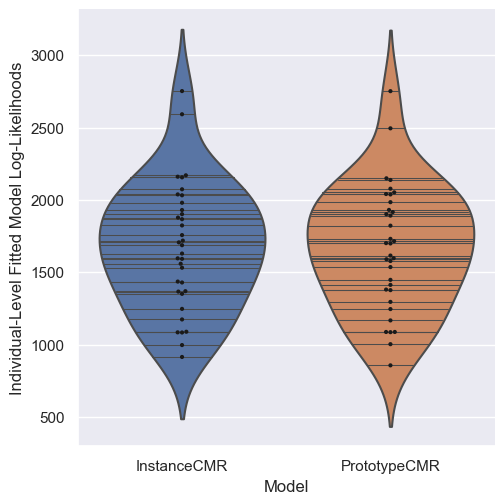

In [18]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects and render summary statistics as table

plt.style.use('default')

individual_fits = [result.fun for result in individual_icmr_results] + [result.fun for result in individual_cmr_results]
labels = ['InstanceCMR'] * len(individual_icmr_results) + ['PrototypeCMR'] * len(individual_cmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_lohnas2014.pdf', bbox_inches="tight")
plt.show()

summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

::: {#fig-lohnasfits layout-ncol=2 layout-valign="center"}

![](individual_lohnas2014.pdf)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |        35     |         35     |
| mean  |      1676.3   |       1668.35  |
| std   |       434.819 |        429.581 |
| min   |       914.375 |        856.293 |
| 25%   |      1367.75  |       1378.27  |
| 50%   |      1686.97  |       1698.98  |
| 75%   |      1955.37  |       1957.65  |
| max   |      2752.36  |       2751.88  |

Log-likelihood score distributions for each subject under each considered model [@siegel2014retrieved]
:::

While follow-up analysis of summary statistics in previous analyses focused on benchmark phenomena such as serial position effects, inclusion of item repetitions in study designs complicates associated visualizations. Instead, we focused comparison on summary statistics measuring classical item repetition effects. In [Figure @fig-lohnas_spacing], we measure how effectively our prototype- and instance-based CMR implementations account for the spacing effect. Main model variants were fit to the mixed list (fourth) condition of the entire dataset across subjects to optimize the likelihood of observed recall sequences. Then with each configured model, study phases of each trial in the mixed condition of the dataset were simulated and then followed with simulation of free recall. We then plot for both the behavioral data and simulated datasets, the rate at which items were recalled, binned based on the number of intervening items between repetitions. On the one hand, we observe that both models poorly account for the pattern of recall rates observed as a function of presentation spacing in the mixed condition of the @siegel2014retrieved dataset, exaggerating the mnemonic benefit of item repetition in general while understating the mnemonic effect of increased spacing between repetitions. On the other hand, recapitulating all previous analyses, we again found that both our prototype-based and main instance-based implementations of CMR predicted similar patterns of effects of repetition spacing on later item recall.

<!--
::: {#fig-lohnasspacings layout-ncol=2}

![Data](figures/data_spacing.png){#fig-dataspacing}

![PrototypeCMR](figures/cmr_spacing.png){#fig-cmr_spacing}

![InstanceCMR](figures/icmr_spacing.png){#fig-icmr_spacing}

Recall probability as a function of spacing between item repetitions, if applicable.
:::
-->

In [ ]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

In [ ]:
#| include: false
print(cmr_result)

In [ ]:
#| output: false
#| code-summary: code -- 2) fit InstanceCMR to entire dataset rather than participant-by-participant

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
#    'feature_sensitivity',
    'context_sensitivity',
    'delay_drift_rate',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)

In [ ]:
#| include: false
print(icmr_result)

In [ ]:
#| code-summary: code -- 3) with PrototypeCMR, compose simulated recall_probability_by_lag from overall fitting results
#| output: false

from compmemlearn.analyses import sim_recall_probability_by_lag


parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for index, name in enumerate(cmr_free_parameters):
    parameters[name] = cmr_result.x[index]
    
parameters['sampling_rule'] = 0
parameters['mfc_familiarity_scale'] = 0
parameters['mcf_familiarity_scale'] = 0
parameters['drift_familiarity_scale'] = 0

@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

selection = list_types == 4
result = sim_recall_probability_by_lag(presentations[selection], 10, init_cmr, parameters)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3

ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=binned)
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.show()

In [ ]:
#| code-summary: code -- 4) with InstanceCMR, compose simulated recall_probability_by_lag from overall fitting results
#| output: false


parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for index, name in enumerate(icmr_free_parameters):
    parameters[name] = icmr_result.x[index]
    
parameters['sampling_rule'] = 0
parameters['choice_sensitivity'] = 1
parameters['feature_sensitivity'] = 1
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

result = sim_recall_probability_by_lag(presentations[selection], 10, init_icmr, parameters)

binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
print(binned)

ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=binned)
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.show()

::: {#fig-lohnas_spacing layout-ncol=3}

![PrototypeCMR](figures/cmr_spacing.png){#fig-cmr_spacing}

![InstanceCMR](figures/icmr_spacing.png){#fig-icmr_spacing}

![Data](figures/data_spacing.png){#fig-data_spacing}

Comparison of predicted recall probability as function of item repetition spacing between each model and the observed data [@siegel2014retrieved].
:::

Research distinguishing two categories of models - instance and prototype theories - has driven progress in various areas of memory science, but the relevance of this distinction to the study of memory search and free recall is mostly unexplored, with prototype models receiving exclusive focus.
We find that instance- and prototype-based variants of a model implementing retrieved context theory can similarly account for performance across a variety of free recall datasets
However, expanded application of likelihood-based comparison framework also helps reveal room for improvement in either model variant’s performance (e.g. repetition memory)!
These results highlight opportunities for bridging innovations developed in one architecture to another through simple transformations of model representations and mechanisms
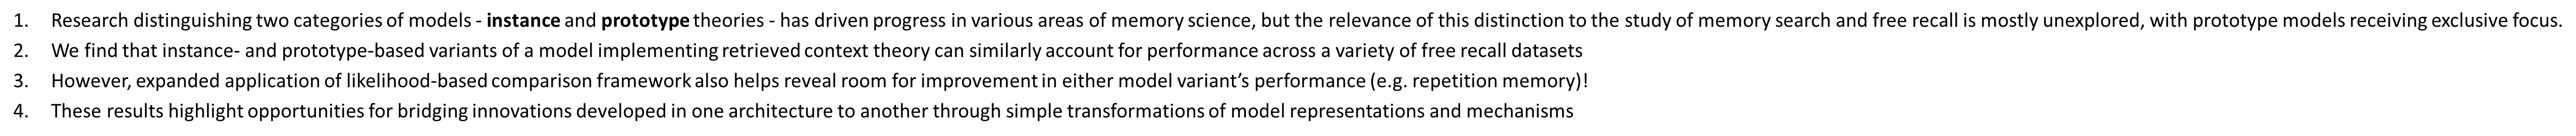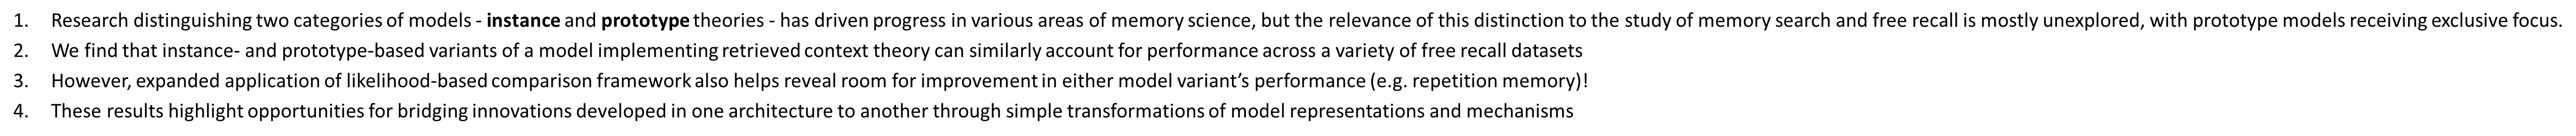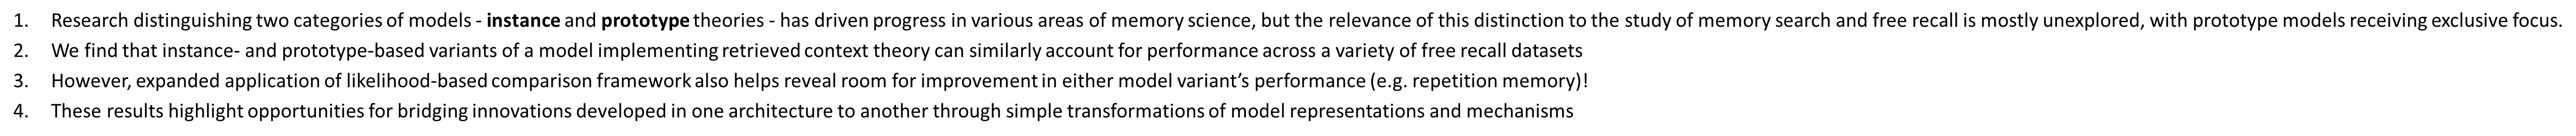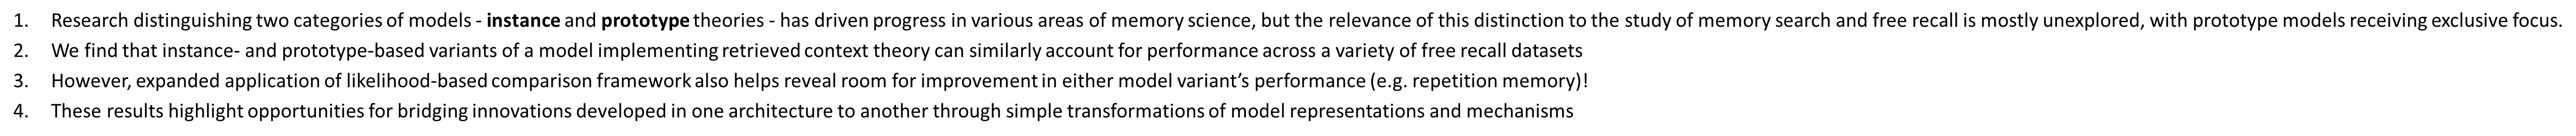